<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import scikitplot as skplt
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow_addons as tfa
from keras import backend as K
import tensorflow as tf

In [3]:
from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm
from collections import defaultdict
import pandas as pd
import numpy as np

In [4]:
import mltle as mlt

Done.


In [6]:
SEED = 7

NUM_RES_BLOCKS = 1
NUM_EPOCHS = 1000
DISCOUNT = 0.9
BATCH_SIZE = 1024

data_path_1 = '../data/data_pKd/'
data_path_2 = '../data/data_pEC50/'
data_type_1 = 'pKd'
data_type_2 = 'pEC50'
model_name = f'Res1CNN_{data_type_1}_{data_type_2}'

In [7]:
tf.keras.backend.clear_session()
np.random.seed(SEED)
tf.random.set_seed(SEED)

model = mlt.training.Model(drug_emb_size=128,
                          protein_emb_size=64,
                          max_drug_len=200,
                          drug_alphabet_len=53,
                          protein_alphabet_len=8006)

order = ['pKi', 'pIC50', 'pKd', 'pEC50', 'is_active', 'qed', 'pH']
loss_weights = [1.0] * len(order)

variables = {}
for var in order:
    variables[var] = K.variable(0.0)

LossCallback = mlt.training_utils.LossWithMemoryCallback(variables, discount=DISCOUNT, decay = 0.8)

uselosses = defaultdict(lambda: mlt.training_utils.mse_loss_wrapper)
uselosses['is_active'] = 'binary_crossentropy'
uselosses['qed'] = 'binary_crossentropy'

for k, v in variables.items():
    if k not in uselosses.keys():
        uselosses[k] = uselosses[k](v)

usemetrics = {data_type_1: [mlt.training_utils.cindex_score], 
              data_type_2: [mlt.training_utils.cindex_score]}

activations = defaultdict(lambda: 'linear')
activations['is_active'] = 'sigmoid'
activations[ 'qed']  = 'sigmoid'

initializer = tf.keras.initializers.VarianceScaling(scale=1., mode='fan_in', distribution='normal', seed=SEED)
optimizer = tfa.optimizers.Lookahead(tf.keras.optimizers.Nadam(), sync_period=3)

model = model.create_model(order=order,
                            activations=activations,
                            activation = 'relu',
                            pooling_mode = 'max',
                            num_res_blocks=NUM_RES_BLOCKS,
                            units_per_head=64,
                            units_per_layer=1024,
                            dropout_rate=0.3,
                            drug_kernel=(2, 3),
                            protein_kernel=(7, 7),
                            loss_weights=loss_weights,
                            usemetrics=usemetrics,
                            uselosses=uselosses,
                            initializer=initializer,
                            optimizer=optimizer,
                            drug_strides_up=1,
                            protein_strides_down=1,
                            positional=False)

2022-08-17 14:36:07.337263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-17 14:36:07.446854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 14:36:07.447030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 14:36:07.447163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Done. Total trainable params: 2391783


In [ ]:
tf.keras.utils.plot_model(model,
                          rankdir='LR',
                          show_shapes=True,
                          show_layer_activations=True,
                          dpi=96)

In [9]:
X_train_1 = pd.read_csv(data_path_1 + f"data_human_agg05_{data_type_1}_train.csv")[['smiles', 'target'] + order]
X_valid_1 = pd.read_csv(data_path_1 + f"data_human_agg05_{data_type_1}_valid.csv")[['smiles', 'target'] + order]
X_test_1 = pd.read_csv(data_path_1 + f"data_human_agg05_{data_type_1}_test.csv")[['smiles', 'target'] + order]

X_train_2 = pd.read_csv(data_path_2 + f"data_human_agg05_{data_type_2}_train.csv")[['smiles', 'target'] + order]
X_valid_2 = pd.read_csv(data_path_2 + f"data_human_agg05_{data_type_2}_valid.csv")[['smiles', 'target'] + order]
X_test_2 = pd.read_csv(data_path_2 + f"data_human_agg05_{data_type_2}_test.csv")[['smiles', 'target'] + order]

X_train = X_train_1.append(X_train_2, ignore_index=True).drop_duplicates().reset_index(drop=True).sample(frac=1)
X_valid = X_valid_1.append(X_valid_2, ignore_index=True).drop_duplicates().reset_index(drop=True).sample(frac=1)
X_test = X_test_1.append(X_test_2, ignore_index=True).drop_duplicates().reset_index(drop=True).sample(frac=1)


X_train.head(2)

/tmp/ipykernel_69096/161696158.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train_1.append(X_train_2, ignore_index=True).drop_duplicates().reset_index(drop=True).sample(frac=1)
/tmp/ipykernel_69096/161696158.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_valid = X_valid_1.append(X_valid_2, ignore_index=True).drop_duplicates().reset_index(drop=True).sample(frac=1)
/tmp/ipykernel_69096/161696158.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test_1.append(X_test_2, ignore_index=True).drop_duplicates().reset_index(drop=True).sample(frac=1)


,smiles,target,pKi,pIC50,pKd,pEC50,is_active,qed,pH
16388,COc1ccc(OC)c2nc3c(C(=O)NCCN(C)C)cccc3nc12,MSTPTDPGAMPHPGPSPGPGPSPGPILGPSPGPGPSPGSVHSMMGP...,NaN,NaN,NaN,4.990970,0.0,0.683298,NaN
25058,O=C(COc1ncnc2ccccc12)c1ccc2c(c1)OCCO2,MDYSYDEDLDELCPVCGDKVSGYHYGLLTCESCKGFFKRTVQNNKH...,NaN,NaN,NaN,6.402195,1.0,0.687829,NaN


In [10]:
mapseq = mlt.datamap.MapSeq(drug_mode='smiles_1',
                            protein_mode='protein_3',
                            max_drug_len=200,
                            max_protein_len=1000)

drug_seqs = np.hstack((X_train['smiles'].unique(), X_valid['smiles'].unique(), X_test['smiles'].unique()))
protein_seqs = np.hstack((X_train['target'].unique(), X_valid['target'].unique(), X_test['target'].unique()))

map_drug, map_protein = mapseq.create_maps(drug_seqs = drug_seqs, protein_seqs = protein_seqs)

  0%|          | 0/69368 [00:00<?, ?it/s]

  0%|          | 0/2699 [00:00<?, ?it/s]

In [11]:
batch_size = BATCH_SIZE

train_gen = mlt.datagen.DataGen(X_train, map_drug, map_protein)
train_gen = train_gen.get_generator(batch_size)

valid_gen = mlt.datagen.DataGen(X_valid, map_drug, map_protein, shuffle=False)
valid_gen = valid_gen.get_generator(batch_size)

In [12]:
steps_per_epoch = X_train.shape[0] // batch_size
valid_steps = X_valid.shape[0] // batch_size

In [13]:
best_model_path = f"Best_{model_name}.h5"
CheckPointCallback = tf.keras.callbacks.ModelCheckpoint(best_model_path,
                                                        monitor=f'val_loss',
                                                        verbose=1,
                                                        save_best_only=True,
                                                        mode='auto',
                                                        save_weights_only=True)

CSVLoggerCallback = tf.keras.callbacks.CSVLogger(f"{model_name}.log")

In [14]:
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=0,
                    callbacks=[TqdmCallback(), CheckPointCallback,
                               LossCallback, CSVLoggerCallback],
                    epochs=NUM_EPOCHS)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-08-17 14:36:27.422692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-17 14:36:28.284886: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-17 14:36:28.285158: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-17 14:36:28.285175: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-17 14:36:28.285390: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-17 14:36:28.285425: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-08-17 14:36:28.621113: I tensorflow/stream_executor/cuda/c


Epoch 1: val_loss improved from inf to 51.47390, saving model to Best_Res1CNN_pKd_pEC50.h5

Epoch 2: val_loss improved from 51.47390 to 26.17706, saving model to Best_Res1CNN_pKd_pEC50.h5

Epoch 3: val_loss improved from 26.17706 to 16.41327, saving model to Best_Res1CNN_pKd_pEC50.h5

Epoch 4: val_loss improved from 16.41327 to 11.90610, saving model to Best_Res1CNN_pKd_pEC50.h5

Epoch 5: val_loss improved from 11.90610 to 10.07059, saving model to Best_Res1CNN_pKd_pEC50.h5

Epoch 6: val_loss did not improve from 10.07059

Epoch 7: val_loss did not improve from 10.07059

Epoch 8: val_loss did not improve from 10.07059

Epoch 9: val_loss did not improve from 10.07059

Epoch 10: val_loss did not improve from 10.07059

Epoch 11: val_loss did not improve from 10.07059

Epoch 12: val_loss did not improve from 10.07059

Epoch 13: val_loss did not improve from 10.07059

Epoch 14: val_loss did not improve from 10.07059

Epoch 15: val_loss improved from 10.07059 to 9.15782, saving model to Bes


Epoch 147: val_loss did not improve from 1.94360

Epoch 148: val_loss did not improve from 1.94360

Epoch 149: val_loss did not improve from 1.94360

Epoch 150: val_loss did not improve from 1.94360

Epoch 151: val_loss did not improve from 1.94360

Epoch 152: val_loss did not improve from 1.94360

Epoch 153: val_loss did not improve from 1.94360

Epoch 154: val_loss did not improve from 1.94360

Epoch 155: val_loss did not improve from 1.94360

Epoch 156: val_loss did not improve from 1.94360

Epoch 157: val_loss did not improve from 1.94360

Epoch 158: val_loss did not improve from 1.94360

Epoch 159: val_loss did not improve from 1.94360

Epoch 160: val_loss did not improve from 1.94360

Epoch 161: val_loss did not improve from 1.94360

Epoch 162: val_loss did not improve from 1.94360

Epoch 163: val_loss did not improve from 1.94360

Epoch 164: val_loss did not improve from 1.94360

Epoch 165: val_loss did not improve from 1.94360

Epoch 166: val_loss did not improve from 1.94360



Epoch 311: val_loss did not improve from 1.94360

Epoch 312: val_loss did not improve from 1.94360

Epoch 313: val_loss did not improve from 1.94360

Epoch 314: val_loss did not improve from 1.94360

Epoch 315: val_loss did not improve from 1.94360

Epoch 316: val_loss did not improve from 1.94360

Epoch 317: val_loss did not improve from 1.94360

Epoch 318: val_loss did not improve from 1.94360

Epoch 319: val_loss did not improve from 1.94360

Epoch 320: val_loss did not improve from 1.94360

Epoch 321: val_loss did not improve from 1.94360

Epoch 322: val_loss did not improve from 1.94360

Epoch 323: val_loss did not improve from 1.94360

Epoch 324: val_loss did not improve from 1.94360

Epoch 325: val_loss did not improve from 1.94360

Epoch 326: val_loss did not improve from 1.94360

Epoch 327: val_loss did not improve from 1.94360

Epoch 328: val_loss did not improve from 1.94360

Epoch 329: val_loss did not improve from 1.94360

Epoch 330: val_loss did not improve from 1.94360



Epoch 475: val_loss did not improve from 1.94360

Epoch 476: val_loss did not improve from 1.94360

Epoch 477: val_loss did not improve from 1.94360

Epoch 478: val_loss did not improve from 1.94360

Epoch 479: val_loss did not improve from 1.94360

Epoch 480: val_loss did not improve from 1.94360

Epoch 481: val_loss did not improve from 1.94360

Epoch 482: val_loss did not improve from 1.94360

Epoch 483: val_loss did not improve from 1.94360

Epoch 484: val_loss did not improve from 1.94360

Epoch 485: val_loss did not improve from 1.94360

Epoch 486: val_loss did not improve from 1.94360

Epoch 487: val_loss did not improve from 1.94360

Epoch 488: val_loss did not improve from 1.94360

Epoch 489: val_loss did not improve from 1.94360

Epoch 490: val_loss did not improve from 1.94360

Epoch 491: val_loss did not improve from 1.94360

Epoch 492: val_loss did not improve from 1.94360

Epoch 493: val_loss did not improve from 1.94360

Epoch 494: val_loss did not improve from 1.94360



Epoch 639: val_loss did not improve from 1.94360

Epoch 640: val_loss did not improve from 1.94360

Epoch 641: val_loss did not improve from 1.94360

Epoch 642: val_loss did not improve from 1.94360

Epoch 643: val_loss did not improve from 1.94360

Epoch 644: val_loss did not improve from 1.94360

Epoch 645: val_loss did not improve from 1.94360

Epoch 646: val_loss did not improve from 1.94360

Epoch 647: val_loss did not improve from 1.94360

Epoch 648: val_loss did not improve from 1.94360

Epoch 649: val_loss did not improve from 1.94360

Epoch 650: val_loss did not improve from 1.94360

Epoch 651: val_loss did not improve from 1.94360

Epoch 652: val_loss did not improve from 1.94360

Epoch 653: val_loss did not improve from 1.94360

Epoch 654: val_loss did not improve from 1.94360

Epoch 655: val_loss did not improve from 1.94360

Epoch 656: val_loss did not improve from 1.94360

Epoch 657: val_loss did not improve from 1.94360

Epoch 658: val_loss did not improve from 1.94360



Epoch 803: val_loss did not improve from 1.94360

Epoch 804: val_loss did not improve from 1.94360

Epoch 805: val_loss did not improve from 1.94360

Epoch 806: val_loss did not improve from 1.94360

Epoch 807: val_loss did not improve from 1.94360

Epoch 808: val_loss did not improve from 1.94360

Epoch 809: val_loss did not improve from 1.94360

Epoch 810: val_loss did not improve from 1.94360

Epoch 811: val_loss did not improve from 1.94360

Epoch 812: val_loss did not improve from 1.94360

Epoch 813: val_loss did not improve from 1.94360

Epoch 814: val_loss did not improve from 1.94360

Epoch 815: val_loss did not improve from 1.94360

Epoch 816: val_loss did not improve from 1.94360

Epoch 817: val_loss did not improve from 1.94360

Epoch 818: val_loss did not improve from 1.94360

Epoch 819: val_loss did not improve from 1.94360

Epoch 820: val_loss did not improve from 1.94360

Epoch 821: val_loss did not improve from 1.94360

Epoch 822: val_loss did not improve from 1.94360



Epoch 967: val_loss did not improve from 1.94360

Epoch 968: val_loss did not improve from 1.94360

Epoch 969: val_loss did not improve from 1.94360

Epoch 970: val_loss did not improve from 1.94360

Epoch 971: val_loss did not improve from 1.94360

Epoch 972: val_loss did not improve from 1.94360

Epoch 973: val_loss did not improve from 1.94360

Epoch 974: val_loss did not improve from 1.94360

Epoch 975: val_loss did not improve from 1.94360

Epoch 976: val_loss did not improve from 1.94360

Epoch 977: val_loss did not improve from 1.94360

Epoch 978: val_loss did not improve from 1.94360

Epoch 979: val_loss did not improve from 1.94360

Epoch 980: val_loss did not improve from 1.94360

Epoch 981: val_loss did not improve from 1.94360

Epoch 982: val_loss did not improve from 1.94360

Epoch 983: val_loss did not improve from 1.94360

Epoch 984: val_loss did not improve from 1.94360

Epoch 985: val_loss did not improve from 1.94360

Epoch 986: val_loss did not improve from 1.94360


In [15]:
[f"{k} : {float(v)}" for k, v in variables.items()]

['pKi : 0.0',
 'pIC50 : 0.0',
 'pKd : 0.0',
 'pEC50 : 0.0',
 'is_active : 0.0',
 'qed : 0.0',
 'pH : 0.0']

In [16]:
model.load_weights(best_model_path)
model.compile()
model.save(f"{model_name}.hdf5")

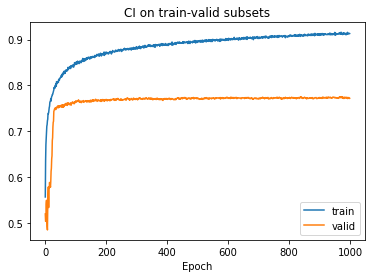

In [17]:
plt.plot(history.history[f'{data_type_1}_cindex_score'], label='train')
plt.plot(history.history[f'val_{data_type_1}_cindex_score'], label='valid')
plt.xlabel('Epoch')
plt.title('CI on train-valid subsets')
plt.legend()

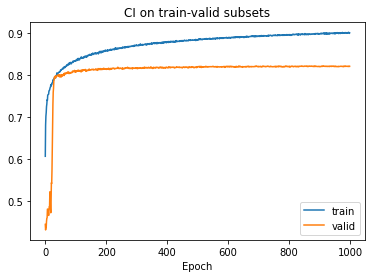

In [18]:
plt.plot(history.history[f'{data_type_2}_cindex_score'], label='train')
plt.plot(history.history[f'val_{data_type_2}_cindex_score'], label='valid')
plt.xlabel('Epoch')
plt.title('CI on train-valid subsets')
plt.legend()

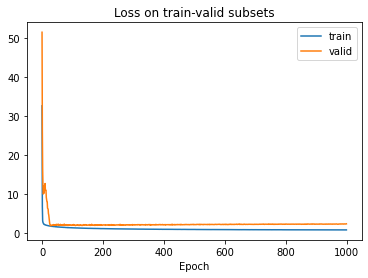

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.title('Loss on train-valid subsets')
plt.legend()

In [20]:
test_batch_size = mlt.training_utils.get_batch_size(X_test.shape[0])
test_batch_size

91

In [21]:
test_gen = mlt.datagen.DataGen(X_test,
                               map_drug,
                               map_protein,
                               shuffle=False,
                               test_only=True)

test_gen = test_gen.get_generator(test_batch_size)

In [22]:
prediction = model.predict(test_gen,
                           steps=X_test.shape[0] // test_batch_size,
                           verbose=1)

305/305 [==============================] - 5s 15ms/step


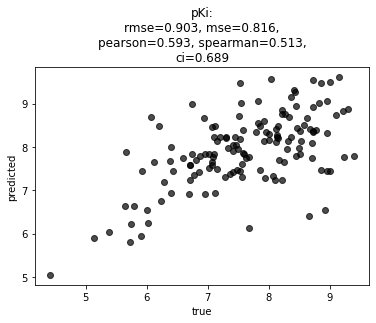

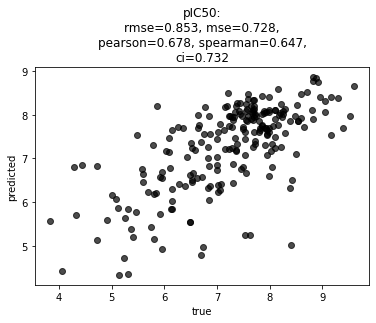

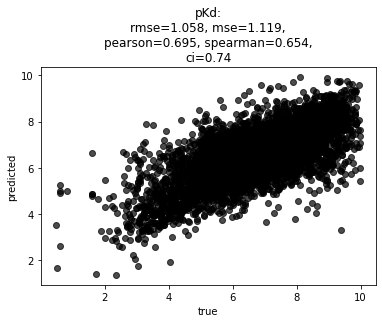

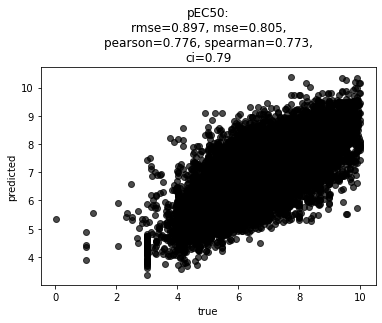

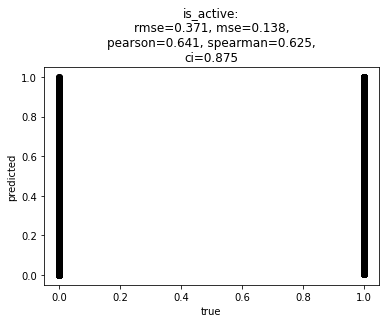

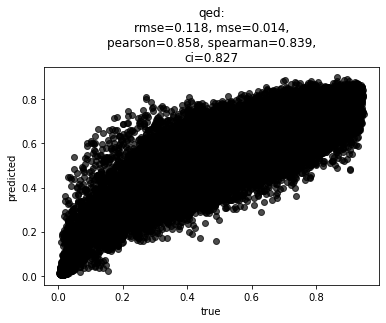

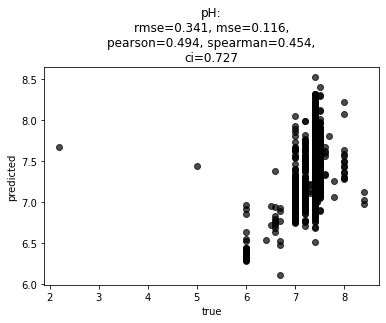

In [23]:
for k, col in enumerate(order):
    try:
        plt.scatter(X_test[col], prediction[k], alpha=0.7, c='k')
        plt.xlabel('true')
        plt.ylabel('predicted')
        y_true = X_test[col][X_test[col].notna()]
        y_pred = prediction[k][X_test[col].notna()].ravel()
        plt.title(col + ":\n" + mlt.training_utils.get_scores(y_true, y_pred))
        plt.show()
    except (ValueError, ZeroDivisionError) as e:
        print(
            f'Empty set test set for: {col}, values sum = {X_test[col].sum()}')
        print(f'or zero concordand pairs for the set of length 1, length of values set = {X_test[col].notna().sum()}')

In [24]:
P = prediction[order.index(data_type_1)].ravel().tolist()
G = X_test[data_type_1].values.tolist()

In [25]:
with open(f'test_{data_type_1}_{model_name}.csv', 'w', encoding='utf-8') as f:
    f.write('true, pred\n')
    for g, p in zip(G, P):
        f.write(f"{g},{p}\n")

In [26]:
P = prediction[order.index(data_type_2)].ravel().tolist()
G = X_test[data_type_2].values.tolist()

In [27]:
with open(f'test_{data_type_2}_{model_name}.csv', 'w', encoding='utf-8') as f:
    f.write('true, pred\n')
    for g, p in zip(G, P):
        f.write(f"{g},{p}\n")